<div style="text-align: center; border: 2px solid #4A90E2; background-color: #F0F8FF; padding: 15px; border-radius: 10px; margin: 20px auto; max-width: 80%;">
  <h1 style="color: black;">🌟 Qwen/Qwen2-VL-2B-Instruct: Document Pages Parsing 🌟</h1>
</div>

This notebook explores the capabilities of the **Qwen/Qwen2-VL-2B-Instruct** model in parsing and analyzing document pages. Designed for robust document understanding, this model leverages advanced vision-language techniques to extract meaningful insights from structured and unstructured documents. In the following sections, we will demonstrate its performance on various document types, evaluate its accuracy, and highlight practical applications for automated document processing.

# **1. Install Libraries**

In [1]:
%%capture
! pip install qwen-vl-utils
! pip install markdown2

# **2. Import Libraries**

In [2]:
import logging
import time
from pathlib import Path
import pandas as pd
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

from IPython.display import display, HTML
import base64
import markdown
import markdown2

import io
from io import BytesIO, StringIO

import warnings
import sys
import contextlib

from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

2025-07-06 15:22:19.872858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751815340.028215      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751815340.071363      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **3. Load Qwen2-VL-2B-Instruct**

In [3]:
# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-2B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
min_pixels = 256*28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

# **4. Inference**

In [4]:
def qen2_vl_2b_inference(image_path, user_query):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image_path,
                },
                {"type": "text", "text": user_query},
            ],
        }
    ]
    
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")
    
    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=2000)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text

In [5]:
def display_text_with_pdf_or_image_plain(raw_text, file_path, pdf_page=0, max_width=800):
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    # --- Image/PDF Display Part ---
    if file_path.lower().endswith(".pdf"):
        images = convert_from_path(file_path, first_page=pdf_page+1, last_page=pdf_page+1)
        img = images[0].convert("RGB")
    else:
        img = Image.open(file_path).convert("RGB")
    
    w_percent = max_width / float(img.width)
    new_height = int(float(img.height) * w_percent)
    img = img.resize((max_width, new_height), Image.LANCZOS)
    
    buffer = BytesIO()
    img.save(buffer, format="JPEG", quality=70)
    img_data = base64.b64encode(buffer.getvalue()).decode()
    html = f"""
    <div style="text-align: center;">
        <img src="data:image/jpeg;base64,{img_data}" style="width: 100%; border: 1px solid #ccc;" />
    </div>
    """
    display(HTML(html))
    # --- Markdown as plain text + tables as DataFrames ---
    html_tables = list(re.finditer(r'(<table[\s\S]*?</table>)', raw_text, re.IGNORECASE))
    last_end = 0
    for match in html_tables:
        text_before = raw_text[last_end:match.start()]
        if text_before.strip():
            print(text_before.strip())
            print('-' * 40)
        table_html = match.group(1)
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", FutureWarning)
                warnings.simplefilter("ignore", RuntimeWarning)
                df_list = pd.read_html(StringIO(table_html))
                for df in df_list:
                    df = df.fillna("")
                    df.columns = df.iloc[0]
                    df = df[1:].reset_index(drop=True)
                    display(df)
        except Exception as e:
            print("Error parsing HTML table:", e)
        last_end = match.end()
    # Print any remaining text after the last table
    if last_end < len(raw_text):
        text_after = raw_text[last_end:].strip()
        if text_after:
            print(text_after)

## **Example n°1**

In [6]:
query = "Convert the given Document page into a Markdown Format, if it contains a chart convert it into a table."

In [9]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-15.jpg",
    query
)


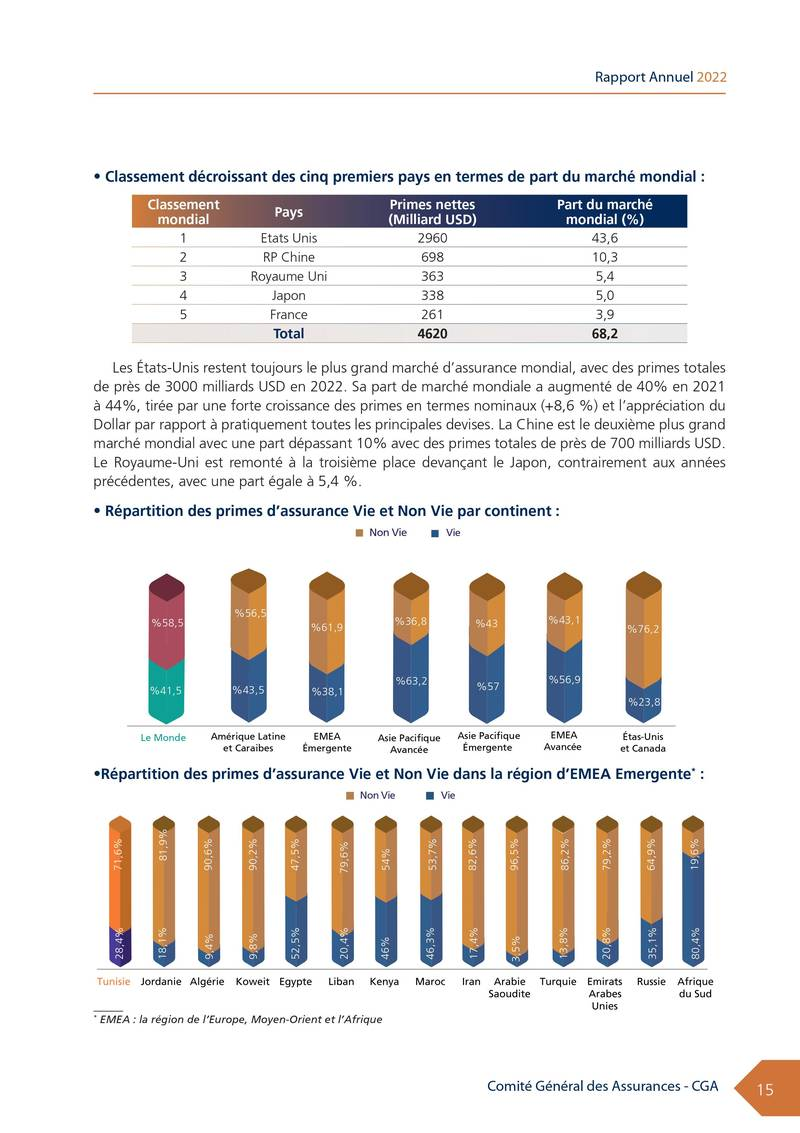

| Classement mondial | Pays | Primes nettes (Milliard USD) | Part du marché mondial (%) |
|---|---|---|---|
| 1 | États-Unis | 2960 | 43,6 |
| 2 | RP Chine | 698 | 10,3 |
| 3 | Royaume Uni | 363 | 5,4 |
| 4 | Japon | 338 | 5,0 |
| 5 | France | 261 | 3,9 |
| Total | 4620 | 68,2 |

Les États-Unis restent toujours le plus grand marché d'assurance mondial, avec des primes totales de près de 3000 milliards USD en 2022. Sa part de marché mondiale a augmenté de 40% en 2021 à 44%, tirée par une forte croissance des primes en termes nominaux (+8,6%) et l'appréciation du Dollar par rapport à pratiquement toutes les principales devises. La Chine est le deuxième plus grand marché mondial avec une part dépassant 10% avec des primes totales de près de 700 milliards USD. Le Royaume-Uni est remonté à la troisième place devantant le Japon, contrairement aux années précédentes, avec une part égale à 5,4%.

| Non Vie | Vie |
|---|---|
| Le Monde | 58,5 | 41,5 |
| Amérique Latine et Caraïbes | 56,5 | 43,5

In [10]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/cga-images/RAP_CGA_FR_ANG_2022-images-15.jpg"
)

## **Example n°2**

In [11]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/different-tables-images-testing/NVIDIA_Report_Removed_Pages-1-16-14_page-0001.jpg",
    query
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.



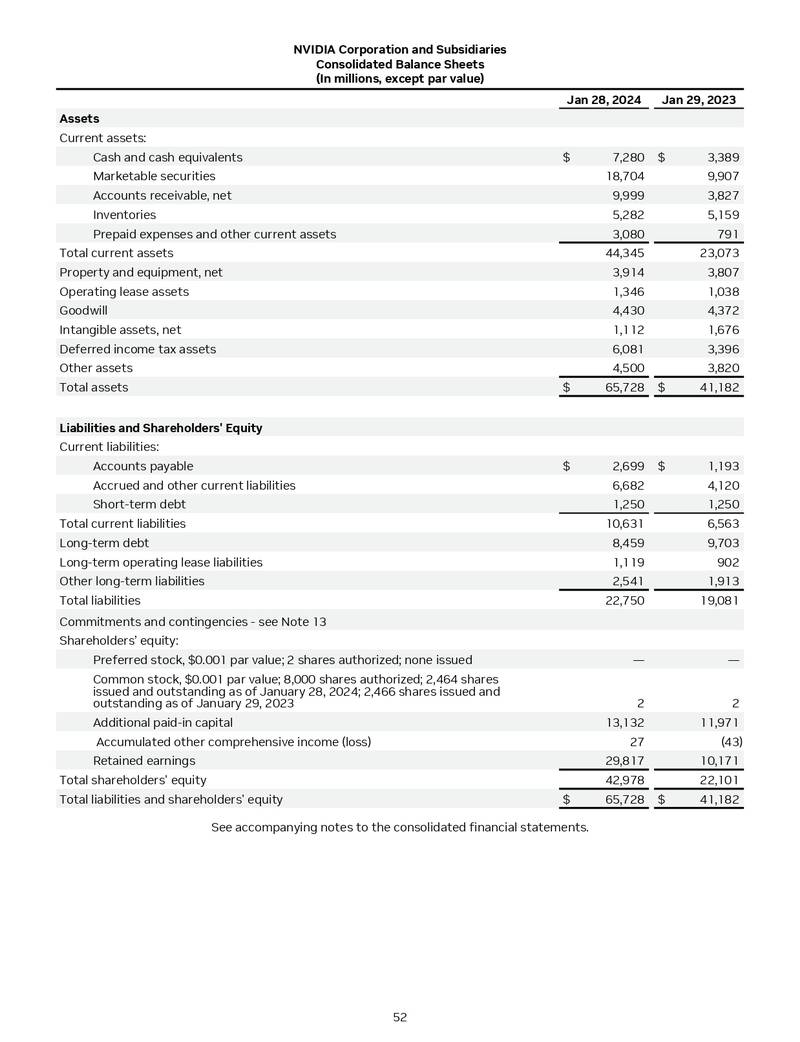

Certainly! Here is the document content converted into Markdown format:

```markdown
# NVIDIA Corporation and Subsidiaries

**Consolidated Balance Sheets**

(in millions, except par value)

| Jan 28, 2024 | Jan 29, 2023 |
| --- | --- |
| Assets |
| Current assets: |
| Cash and cash equivalents | $ 7,280 | $ 3,389 |
| Marketable securities | 18,704 | 9,907 |
| Accounts receivable, net | 9,999 | 3,827 |
| Inventories | 5,282 | 5,159 |
| Prepaid expenses and other current assets | 3,080 | 791 |
| Total current assets | 44,345 | 23,073 |
| Property and equipment, net | 3,914 | 3,807 |
| Operating lease assets | 1,346 | 1,038 |
| Goodwill | 4,430 | 4,372 |
| Intangible assets, net | 1,112 | 1,676 |
| Deferred income tax assets | 6,081 | 3,396 |
| Other assets | 4,500 | 3,820 |
| Total assets | $ 65,728 | $ 41,182 |
| Liabilities and Shareholders' Equity |
| Current liabilities: |
| Accounts payable | $ 2,699 | $ 1,193 |
| Accrued and other current liabilities | 6,682 | 4,120 |
| Short-term 

In [12]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/different-tables-images-testing/NVIDIA_Report_Removed_Pages-1-16-14_page-0001.jpg"
)

## **Example n°3**

In [13]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/different-tables-images-testing/NVIDIA_Report_Removed_Pages-1-16-5_page-0001.jpg",
    query
)


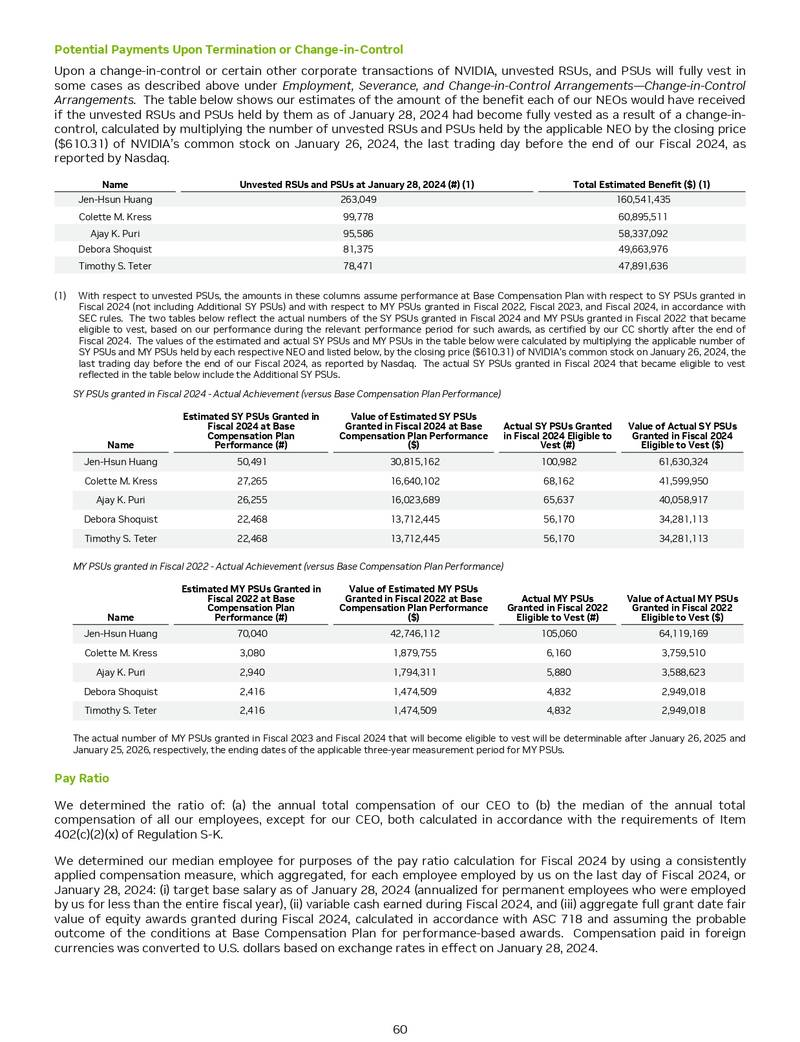

```markdown
# Potential Payments Upon Termination or Change-in-Control

Upon a change-in-control or certain other corporate transactions of NVIDIA, unvested RSUs, and PSUs will fully vest in some cases as described above under **Employment, Severance, and Change-in-Control Arrangements—Change-in-Control Arrangements**. The table below shows our estimates of the amount of the benefit each of our NEOs would have received if the unvested RSUs and PSUs held by them as of January 28, 2024 had become fully vested as a result of a change-in-control, calculated by multiplying the number of unvested RSUs and PSUs held by the applicable NEO by the closing price ($610.31) of NVIDIA's common stock on January 26, 2024, the last trading day before the end of our Fiscal 2024, as reported by Nasdaq.

| Name | Unvested RSUs and PSUs at January 28, 2024 (#) (1) | Total Estimated Benefit ($) (1) |
|------|------------------------------------|------------------------------------|
| Jen-Hsun Huang | 263,04

In [14]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/different-tables-images-testing/NVIDIA_Report_Removed_Pages-1-16-5_page-0001.jpg"
)

## **Example n°4**

In [15]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/different-tables-images-testing/other_table.jpg",
    query
)


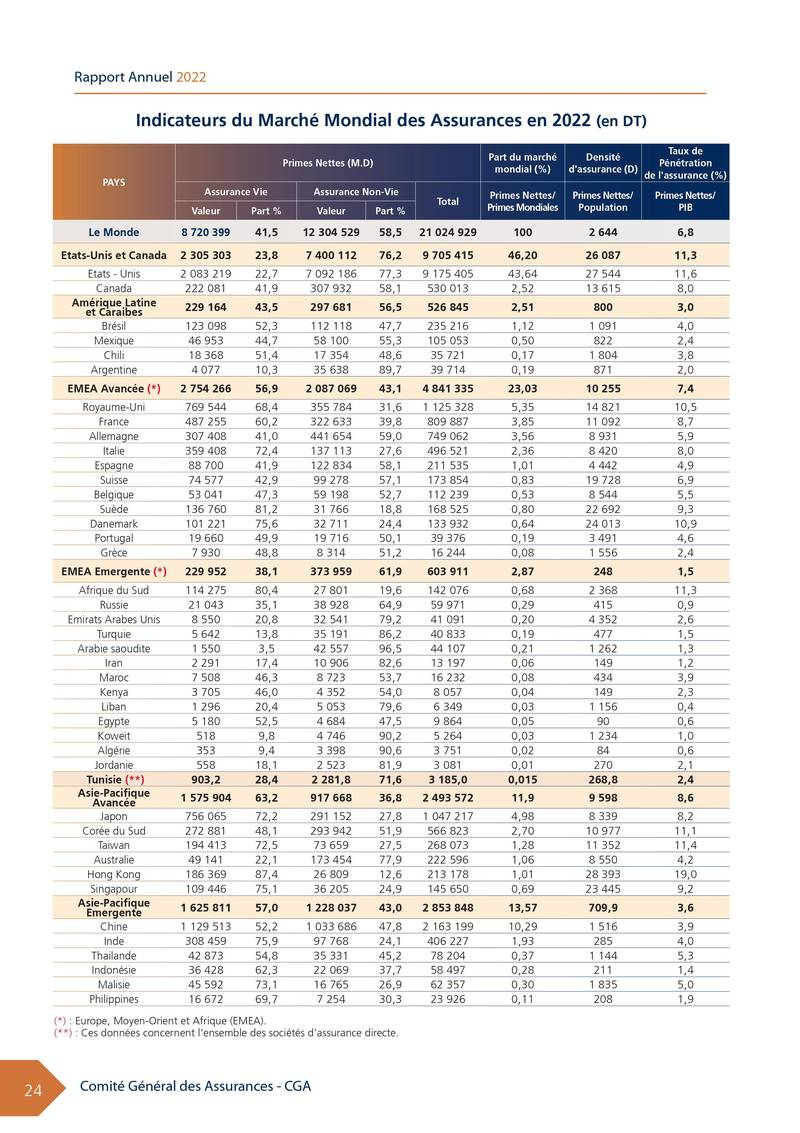

| PAYS | PRIMES NETTES (M.D.) | PART DU MARCHÉ MONDIAL (%) | DENSITÉ D'ASSURANCE (D) | Taux de Pénétration de l'assurance (%) |
|---|---|---|---|---|
| LE MONDE | 8 720 399 | 41,5 | 12 304 529 | 58,5 | 21 024 929 | 100 | 2 644 | 6,8 |
| ÉTATS-UNIS ET CANADA | 2 305 303 | 23,8 | 7 400 112 | 76,2 | 9 705 415 | 46,20 | 26 087 | 11,3 |
| ÉTATS-UNIS | 2 083 219 | 22,7 | 7 092 186 | 77,3 | 9 175 405 | 43,64 | 27 544 | 11,6 |
| CANADA | 222 081 | 41,9 | 307 932 | 58,1 | 530 013 | 2,52 | 13 615 | 8,0 |
| AMÉRIQUE LATINE ET CARIBÉE | 229 164 | 43,5 | 297 681 | 56,5 | 526 845 | 2,51 | 800 | 3,0 |
| BRÉSIL | 123 098 | 52,3 | 112 118 | 47,7 | 235 216 | 1,12 | 1 091 | 4,0 |
| MEXIQUE | 46 953 | 44,7 | 58 100 | 55,3 | 105 053 | 0,50 | 822 | 2,4 |
| CHILI | 18 368 | 51,4 | 17 354 | 48,6 | 35 721 | 0,17 | 1 804 | 3,8 |
| ARGENTINE | 4 077 | 10,3 | 35 638 | 89,7 | 39 714 | 0,19 | 871 | 2,0 |
| EMEA AVANCÉE (*) | 2 754 266 | 56,9 | 2 087 069 | 43,1 | 4 841 335 | 23,03 | 10 255 | 7,4 |
| ROYAUME-UNI | 76

In [16]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/different-tables-images-testing/other_table.jpg"
)

## **Example n°5**

In [17]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/different-tables-images-testing/other_table_big.jpg",
    query
)


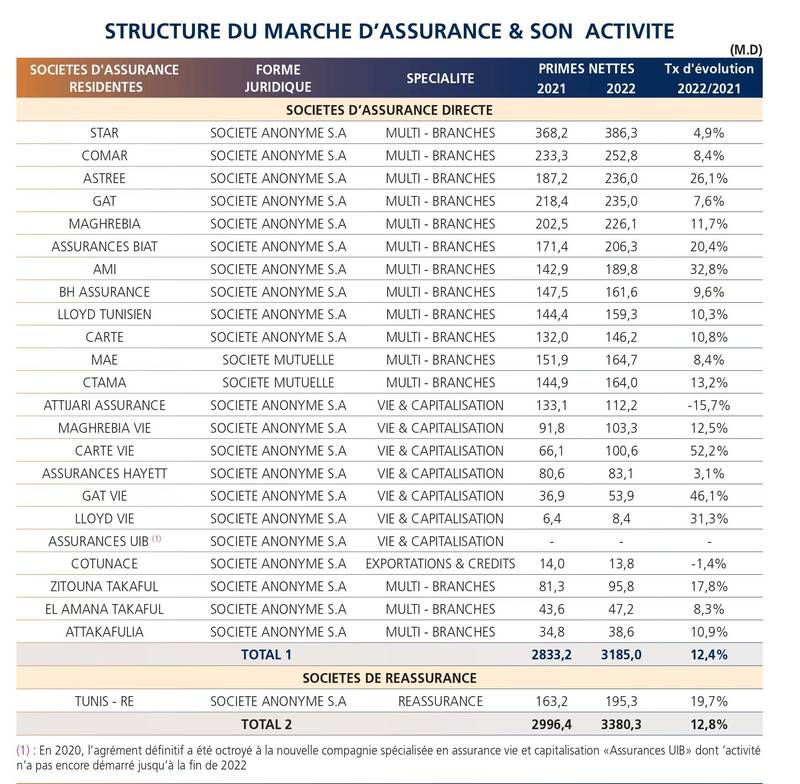

Certainly! Here is the table converted from the given Document page:

| Sociétés d'Assurance Residentes | Forme Juridique | Specialité | Primes Nettes 2021 | Taux d'évolution 2022/2021 |
|---|---|---|---|---|
| STAR | Société Anonyme S.A. | Multi - Branches | 368,2 | 4,9% |
| COMAR | Société Anonyme S.A. | Multi - Branches | 233,3 | 8,4% |
| ASTREE | Société Anonyme S.A. | Multi - Branches | 187,2 | 26,1% |
| GAT | Société Anonyme S.A. | Multi - Branches | 218,4 | 7,6% |
| MAGHREBIA | Société Anonyme S.A. | Multi - Branches | 202,5 | 11,7% |
| ASSURANCES BIAT | Société Anonyme S.A. | Multi - Branches | 171,4 | 20,4% |
| AMI | Société Anonyme S.A. | Multi - Branches | 142,9 | 32,8% |
| BH ASSURANCE | Société Anonyme S.A. | Multi - Branches | 147,5 | 9,6% |
| LLOYD TUNISIEN | Société Anonyme S.A. | Multi - Branches | 144,4 | 10,3% |
| CARTE | Société Anonyme S.A. | Multi - Branches | 132,0 | 10,8% |
| MAE | Société Mutuelle | Multi - Branches | 151,9 | 8,4% |
| CTAMA | Société Mutuelle |

In [18]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/different-tables-images-testing/other_table_big.jpg"
)

## **Example n°6**

In [19]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/pdf-files-pages/Blackstone4Q24EarningsPressRelease_page-0010.jpg",
    query
)


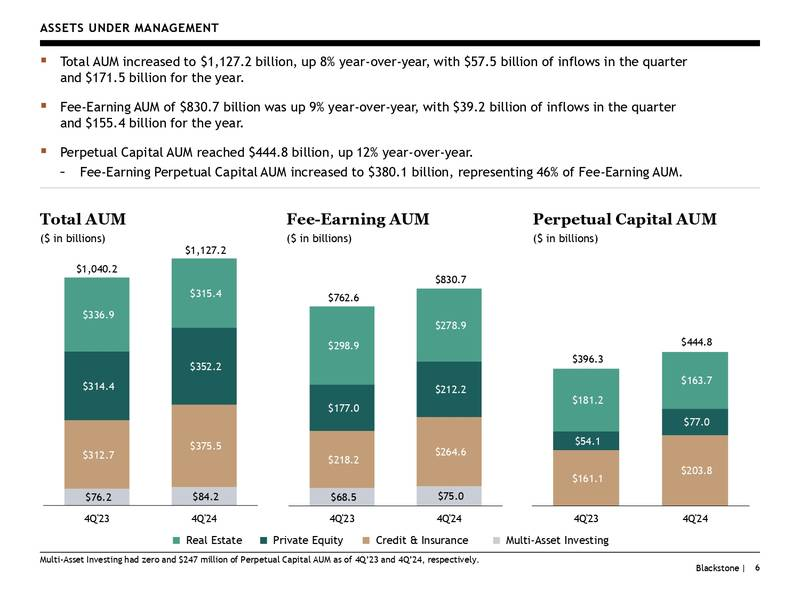

Certainly! Here is the Markdown format of the given Document page with the chart converted into a table:

---

**ASSETS UNDER MANAGEMENT**

| **ASSET CLASS** | **4Q'23** | **4Q'24** |
|------------------|------------|------------|
| **Total AUM** | $1,040.2  | $1,127.2  |
| **Fee-Earning AUM** | $336.9    | $315.4    |
| **Perpetual Capital AUM** | $76.2     | $84.2     |

---

**Multi-Asset Investing** had zero and $247 million of Perpetual Capital AUM as of 4Q'23 and 4Q'24, respectively.

---

**ASSETS UNDER MANAGEMENT**

| **ASSET CLASS** | **4Q'23** | **4Q'24** |
|------------------|------------|------------|
| **Total AUM** | $1,040.2  | $1,127.2  |
| **Fee-Earning AUM** | $336.9    | $315.4    |
| **Perpetual Capital AUM** | $76.2     | $84.2     |

---

**Multi-Asset Investing** had zero and $247 million of Perpetual Capital AUM as of 4Q'23 and 4Q'24, respectively.

---

**ASSETS UNDER MANAGEMENT**

| **ASSET CLASS** | **4Q'23** | **4Q'24** |
|------------------|------------|---

In [20]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/pdf-files-pages/Blackstone4Q24EarningsPressRelease_page-0010.jpg"
)

## **Example n°7**

In [21]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/pdf-files-pages/Blackstone4Q24EarningsPressRelease_page-0020.jpg",
    query
)


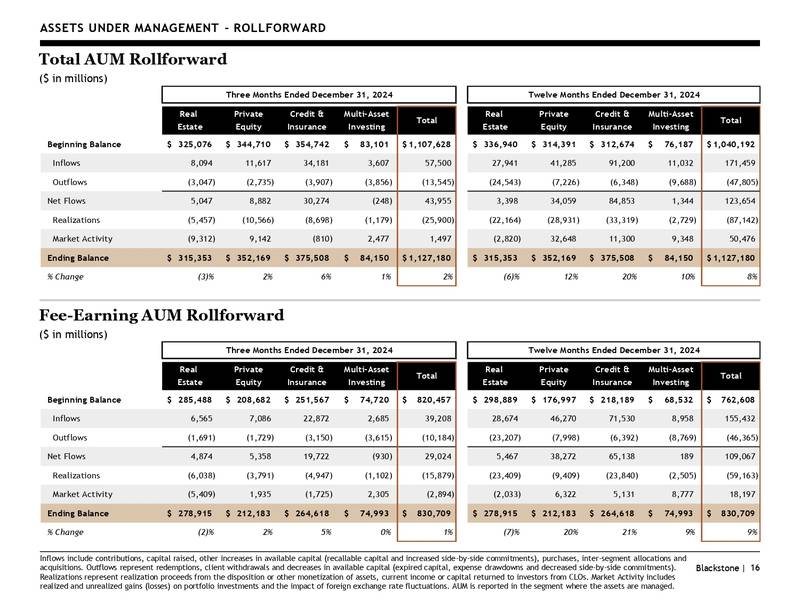

Certainly! Here is the document page converted into Markdown format:

---

**ASSETS UNDER MANAGEMENT - ROLLFORWARD**

| **Total AUM Rollforward** | Three Months Ended December 31, 2024 |
| --- | --- |
| Real Estate | $315,353 |
| Private Equity | $352,169 |
| Credit & Insurance | $375,508 |
| Multi-Asset Investing | $84,150 |
| Total | $1,127,180 |

| **Three Months Ended December 31, 2024** |
| --- |
| Real Estate | $325,076 |
| Private Equity | $344,710 |
| Credit & Insurance | $354,742 |
| Multi-Asset Investing | $83,101 |
| Total | $1,107,628 |

| **Twelve Months Ended December 31, 2024** |
| --- |
| Real Estate | $336,940 |
| Private Equity | $314,391 |
| Credit & Insurance | $312,674 |
| Multi-Asset Investing | $76,187 |
| Total | $1,040,192 |

| **Three Months Ended December 31, 2024** |
| --- |
| Real Estate | $336,940 |
| Private Equity | $314,391 |
| Credit & Insurance | $312,674 |
| Multi-Asset Investing | $76,187 |
| Total | $1,040,192 |

| **Twelve Months Ended December 31

In [22]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/pdf-files-pages/Blackstone4Q24EarningsPressRelease_page-0020.jpg"
)

## **Example n°8**

In [23]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0031.jpg",
    query
)


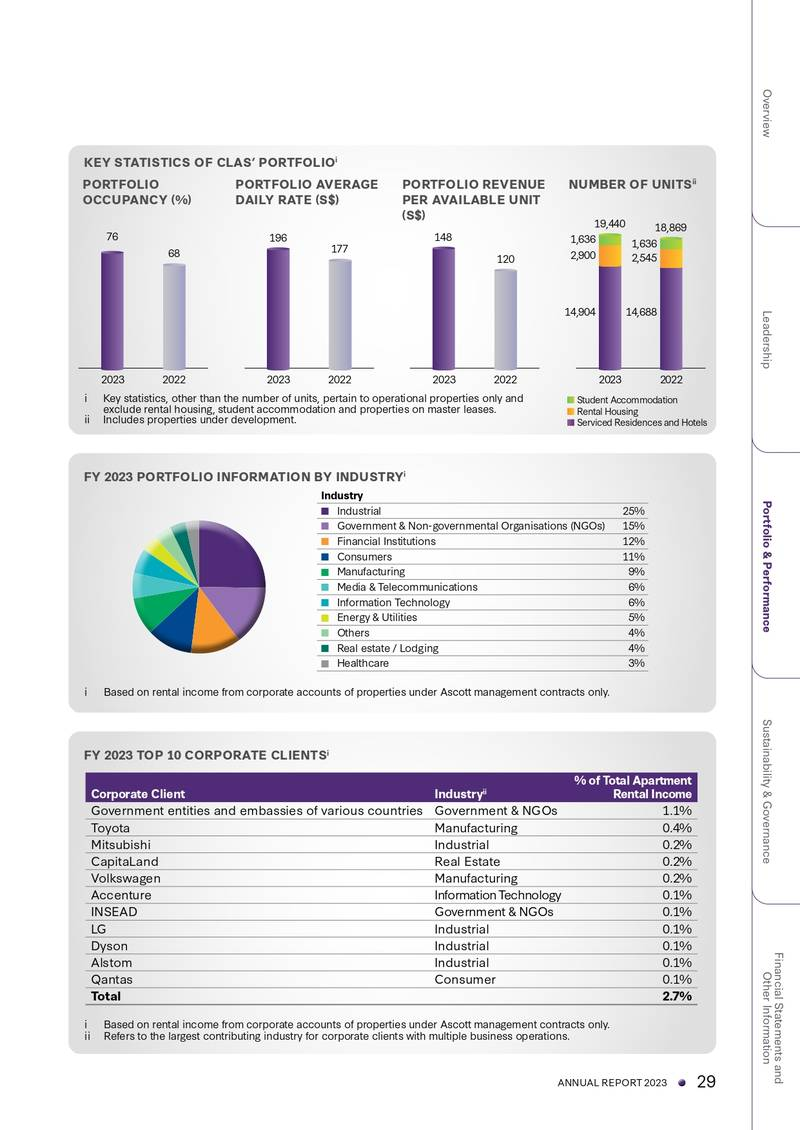

| Corporate Client | Industry | % of Total Apartment Rental Income |
| --- | --- | --- |
| Government entities and embassies of various countries | Government & NGOs | 1.1% |
| Toyota | Manufacturing | 0.4% |
| Mitsubishi | Industrial | 0.2% |
| CapitalLand | Real Estate | 0.2% |
| Volkswagen | Manufacturing | 0.2% |
| Accenture | Information Technology | 0.1% |
| INSEAD | Government & NGOs | 0.1% |
| LG | Industrial | 0.1% |
| Dyson | Industrial | 0.1% |
| Alstom | Industrial | 0.1% |
| Qantas | Consumer | 0.1% |
| Total | 2.7% |


In [24]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/pdf-files-pages/CLAS-FY2023-AR_page-0031.jpg"
)

## **Example n°9**

In [25]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/pdf-files-pages/RHG_annual_report_2022_page-0047.jpg",
    query
)


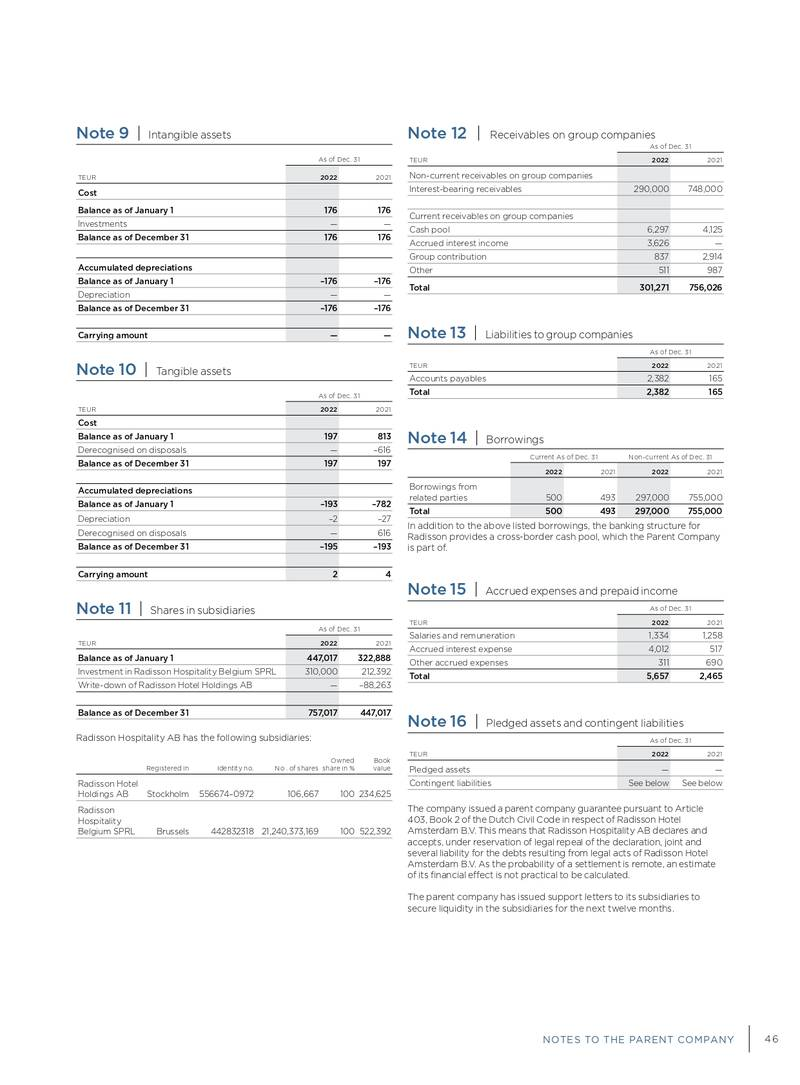

Certainly! Here is the document converted into Markdown format:

```markdown
# Notes to the Parent Company

## Notes to the Parent Company

**Note 9 | Intangible assets**

| As of Dec. 31 |
|---|
| TEUR |
| 2022 |
| 2021 |
| Cost |
| --- |
| Balance as of January 1 |
| 176 |
| 176 |
| Investments |
| --- |
| Balance as of December 31 |
| 176 |
| 176 |
| Accumulated depreciations |
| Balance as of January 1 |
| -176 |
| -176 |
| Depreciation |
| --- |
| Balance as of December 31 |
| -176 |
| -176 |
| Carrying amount |
| --- |
| Balance as of January 1 |
| -176 |
| -176 |
| Accumulated depreciations |
| Balance as of January 1 |
| -193 |
| -782 |
| Depreciation |
| -2 |
| -27 |
| Derecognised on disposals |
| --- |
| Balance as of December 31 |
| -195 |
| -193 |
| Carrying amount |
| 2 |
| 4 |

**Note 10 | Tangible assets**

| As of Dec. 31 |
|---|
| TEUR |
| 2022 |
| 2021 |
| Cost |
| Balance as of January 1 |
| 197 |
| 813 |
| Derecognised on disposals |
| --- |
| Balance as of Decembe

In [26]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/pdf-files-pages/RHG_annual_report_2022_page-0047.jpg"
)

## **Example n°10**

In [27]:
generated_result = qen2_vl_2b_inference(
    "/kaggle/input/pdf-files-pages/Blackstone4Q24EarningsPressRelease_page-0013.jpg",
    query
)


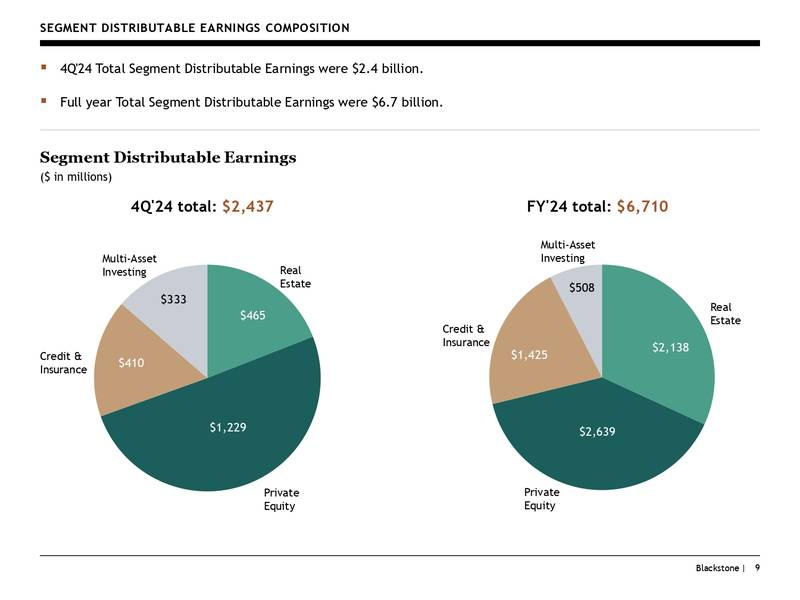

Certainly! Here is the Markdown format of the given document page:

```markdown
# SEGMENT DISTRIBUTABLE EARNINGS COMPOSITION

### 4Q'24 Total Segment Distributable Earnings were $2.4 billion.
### Full year Total Segment Distributable Earnings were $6.7 billion.

### Segment Distributable Earnings
($ in millions)

| Segment | Distributable Earnings |
|---------|------------------------|
| Multi-Asset | $333                  |
| Real Estate | $465                  |
| Credit & | $410                  |
| Insurance | $1,229                |
| Private Equity | $1,425                |

### FY'24 total: $6,710

| Segment | Distributable Earnings |
|---------|------------------------|
| Multi-Asset | $508                  |
| Real Estate | $2,138                |
| Credit & | $2,639                |
| Insurance | $2,639                |
| Private Equity | $2,639                |

Blackstone | 9
```

This table converts the pie chart into a table format.


In [28]:
display_text_with_pdf_or_image_plain(
    generated_result[0],
    "/kaggle/input/pdf-files-pages/Blackstone4Q24EarningsPressRelease_page-0013.jpg"
)